# Authorship Verification

In [1]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import scipy.spatial.distance as scidist

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import mpl_axes_aligner

## Loading

In [2]:
def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        verse.append(('n(prop)', 'n(prop)'))
                    else:
                        verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [3]:
import lxml.etree

def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text if l.text else "" for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text if p.text else "" for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            lemma = lemma or ""  # Ensure lemma is not None
            pos = pos or ""      # Ensure pos is not None
            
            for l, p in zip(lemma.split('+'), pos.split('+')):
                if p == 'n(prop)':
                    verse.append(('n(prop)', 'n(prop)'))
                else:
                    verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [5]:
meta_df = pd.read_excel('../data/metadata_corrected-BY-one.xlsx')
meta_df = meta_df[meta_df['genre'] == 'Epiek']
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,provenance,date_range,genre,subgenre,exclude
252,van_den_neghen_besten__kort,Van den neghen besten (kort),NaN,cdrom-mnl,1475-1500,Epiek,Didactiek,NaN
12,beerte_metten_breden_voeten,Beerte metten breden voeten,NaN,cdrom-mnl,1375-1425,Epiek,Karel,NaN
23,borchgravinne_van_vergi__1,Borchgravinne van Vergi (1),NaN,cdrom-mnl,1400-1420,Epiek,Ridder,NaN
134,merlijns_boec,Merlijns boec,Jacob van Maerlant,cdrom-mnl,1300-1350,Epiek,Arthur,NaN
215,spiegel_der_sonden_fragm_ge1,Spiegel der sonden,NaN,cdrom-mnl,1300-1400,Epiek,Didactiek,NaN
284,wrake_van_ragisel,Wrake van Ragisel,NaN,cdrom-mnl,1300-1350,Epiek,Arthur,NaN
226,spiegel_historiael__4_velthem__fragm_ge1,Spiegel historiael (P4),Lodewijk van Velthem,cdrom-mnl,1300-1325,Epiek,Historiografie,NaN
153,ongeidentificeerd_6,Ongeïdentificeerd (6),NaN,cdrom-mnl,1375-1400,Epiek,Karel,NaN
147,ogier_van_denemarken_fragm_k,Ogier van Denemarken,NaN,cdrom-mnl,1300-1400,Epiek,Karel,NaN
211,spiegel_der_jongers,Spiegel der jongers,Lambertus Goetman,cdrom-mnl,1510-1520,Epiek,Didactiek,NaN


In [7]:
works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml_galahad_BY-one/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'subgenre', 'text'])

Wrake van Ragisel                                 : 100%|█| 162/162 [00:09<00:00


## Segmentation 

In [8]:
len(work_df[work_df['title'].str.contains('Eduwaert')]['text'].iloc[0])

2018

In [9]:
def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['subgenre']]
        
        if row['title'] == 'Van Saladijn':
            text = text[::2] + text[1::2]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=2000)
segment_df.sample(5)

100%|███████████████████████████████████████| 162/162 [00:00<00:00, 1126.23it/s]


,title,author,genre,subgenre,segment-idx,text
224,Sinte Franciscus leven,Jacob van Maerlant,Epiek,Heiligenleven,1,"[einde, schende, zeggen, liggen, zullen, verdollen, minnen, winnen, keren, leren, verstaan, gaan, meest, geest, goed, schoeën, slapen, paap, dan, man, spoed, goed, zeer, eer, zot, God, zak, gemak, vergeten, splijten, bekend, minnen, langeloot, galenhoot, ongeboren, horen, strijd, wijd, zwaar, waar, klare, waar, geschieden, zien, dan, onnen, varen, zijn, voorspreken, gemak, waken, naken, verliezen, riezen, tijd, zijde, voortkomen, versmoren, goed, overmoed, zullen, willen, openbaar, zijn, dragen, jagen, rood, groot, zenden, einde, geven, af, bede, stede, bidden, gestaden, patroon, loon, gevader, vergaderen, heer, keren, mede, vrede, avontuur, keur, na, haast, leven, geven, vite, habijt, genaken, maken, zetten, wet, wassen, dies, zuur, creatuur, ...]"
42,Commentaar op het Hooglied,NaN,Epiek,Religie,5,"[onrein, verstaan, waan, leven, sneven, tijgen, niet, wederstaan, ontvangen, bruut, uit, gestaan, Libanon, zonde, binden, wezen, genezen, niemand, onnen, Amana, Judea, ongetogen, loge, kerstenheid, zaligheid, sacrament, bekend, gaan, libaan, klaarheid, kleit, nemen, komen, zondelijkheid, liggen, doop, lopen, hier, Samier, heten, weten, zijne, pijn, bruut, vutten, doen, ootmoed, Libanon, aanzien, schoon, kroon, zonde, binden, misdaad, genade, verwaten, baten, lang, bedwang, Hermoen, doen, verwatenheid, leggen, hebben, leven, schoon, Hermone, zonde, binden, misdaad, genaden, werk, sterken, hol, vol, jagen, bedragen, dood, albloot, bezien, verdriet, betering, ding, libaan, staan, wonen, kreunen, gene, een, aanvachten, vlechten, Dieu, brief, woord, moorden, unijn, zijn, menigerhande, hand, bedriegen, ...]"
227,Sinte Franciscus leven,Jacob van Maerlant,Epiek,Heiligenleven,4,"[gedachte, dag, lachen, leven, geven, verstaan, doen, openbaar, waar, aan, man, kennen, einden, mee, zee, vaart, Ledenaard, tijd, rijden, neren, zwaar, spreken, verbreken, mijn, lijn, gaan, nemen, bijten, reden, misdaad, gaan, stuk, ik, groot, rood, vinden, hand, volbrengen, gedachte, mede, genadigheid, goed, moet, zijn, mare, hellen, tellen, zijn, schaar, gedenken, zoeken, aan, man, doen, heimelijkheid, man, onnen, onzacht, gedachte, heimelijkheid, mede, voren, verkiezen, uitermate, baat, onnen, man, genade, laden, lachen, dag, zeer, heer, schrijven, geven, willen, zullen, geeste, vollezen, ontgaan, zaan, binnen, zin, verwinnen, man, bedekken, vertrekken, zenden, perkament, brief, lieve, hand, vinden, ontvangen, gaan, behoeden, goed, begeren, vaart, daar, ...]"
70,Dietsche Lucidarius,NaN,Epiek,Didactiek,1,"[koningin, zin, vermanen, zoon, zondaar, zwaar, sterven, bederven, geest, meest, zenden, voleinden, hemelrijk, getrouwelijk, drivuldigheid, gebed, ontsteken, gebrek, lucidaris, zijn, baat, verlaten, vader, algader, confessor, horen, vermanen, staan, drievuldigheid, bede, verklaren, zijn, innen, begin, God, gebod, vecht, berechten, lieden, beduiden, vader, gader, zijn, fijn, spreken, beluiken, de, zijn, zekerlijk, hemelrijk, mogendheid, overwijsheid, klaarheid, zeggen, troon, schonen, aanzicht, licht, onverzadelijk, hemelrijk, niet, zien, klaar, daar, verlang, lang, gezijn, wijltje, almachtigheid, stede, wezen, lezen, waan, bevangen, hoon, persoon, God, gebod, hel, vertellen, beginsel, wel, ie, drie, geschieden, drie, schoon, troen, proeven, behoeven, ding, zonderling, zijn, vurine, hitte, dit, zien, drie, deze, wezen, ...]"
242,Spiegel historiael (P1-P4),Jacob van Maerlant,Epiek,Historiografie,11,"[zoon, gene, Galylea, zee, wil, stil, hand, band, land, vinden, bezitten, vergeten, bidden, schaden, wort, versmoren, stad, dat, woeden, nijden, voet, boete, zonde, stond, land, hand, heten, ontbijten, mede, stede, aan, samaritaan, haar, schaar, datgene, zunnen, zijn, genezen, eten, stad, zijn, zondaar, dood, groot, wijf, lijf, zien, nadien, spreken, ongemak, zetten, Nazaret, heten, verlaten, zwaar, neren, gevaan, verstaan, doen, twijfelheid, zijn, aldaar, 

In [10]:
len(segment_df[segment_df['title'].str.contains('duwaert')]['text'].iloc[0])

2000

## Combinations

In [14]:
calib_df = segment_df[segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem'})]
trg_df = segment_df[segment_df['title'].isin({'Brabantsche yeesten (B1-5)',
                                              'Korte kroniek van Brabant (korte versie 1)',
                                              'Der leken spieghel',
                                              'Jans teesteye',
                                              'Van den derden Eduwaert',
                                              'Melibeus',
                                              'Boec Exemplaer',
                                              'Dietsche doctrinale',
                                              'Boec vander wraken',})]
                                              # 
                                              
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']

#calib_df = calib_df[calib_df['title'] != 'Heymelijchede der heymelijcheit']

In [15]:
calib_df[['author', 'title']].value_counts()

author                title                          
Jacob van Maerlant    Spiegel historiael (P1-P4)         44
                      Historie van Troyen                20
                      Rijmbijbel                         17
Lodewijk van Velthem  Spiegel historiael (P5)            13
                      Merlijn-continuatie                12
Jacob van Maerlant    Der naturen bloeme                 8 
                      Alexanders geesten                 7 
                      Sinte Franciscus leven             5 
Lodewijk van Velthem  Spiegel historiael (P4)            3 
Jacob van Maerlant    Heymelijchede der heymelijcheit    1 
Name: count, dtype: int64

In [16]:
trg_df[['title']].value_counts()

title                     
Der leken spieghel            11
Brabantsche yeesten (B1-5)    8 
Dietsche doctrinale           3 
Boec vander wraken            2 
Jans teesteye                 2 
Melibeus                      1 
Van den derden Eduwaert       1 
Name: count, dtype: int64

In [17]:
combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
print(combos['authorship'].value_counts())
combos.sample(5)

authorship
S    24
D    21
Name: count, dtype: int64


,title1,title2,authorship
9,Der naturen bloeme,Heymelijchede der heymelijcheit,S
42,Merlijn-continuatie,Spiegel historiael (P4),S
22,Heymelijchede der heymelijcheit,Spiegel historiael (P4),D
18,Heymelijchede der heymelijcheit,Rijmbijbel,S
33,Rijmbijbel,Spiegel historiael (P4),D


In [18]:
def identity(x):
    return x

def bigrams(text):
    for i in range(len(text)-1):
        if 'n(prop)' not in text[i:i+2]:
            yield '-'.join((sorted(text[i:i+2])))
            
def unigrams(text):
    for i in range(len(text)):
        if 'n(prop)' not in text[i]:
            yield text[i]

params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(list(calib_df['text']) + list(trg_df['text']))
X = vectorizer.transform(calib_df['text']).toarray()

In [19]:
calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances = calib_distances[~calib_distances['distance'].isna()]
calib_distances

,title1,title2,authorship,distance
0,Alexanders geesten,Der naturen bloeme,S,0.945307
1,Alexanders geesten,Der naturen bloeme,S,0.897320
2,Alexanders geesten,Der naturen bloeme,S,0.912986
3,Alexanders geesten,Der naturen bloeme,S,0.903167
4,Alexanders geesten,Der naturen bloeme,S,0.899431
...,...,...,...,...
6902,Spiegel historiael (P4),Spiegel historiael (P5),S,0.729753
6903,Spiegel historiael (P4),Spiegel historiael (P5),S,0.718348
6904,Spiegel historiael (P4),Spiegel historiael (P5),S,0.671286
6905,Spiegel historiael (P4),Spiegel historiael (P5),S,0.708077


max(f1)=0.0 @ theta=0.1048


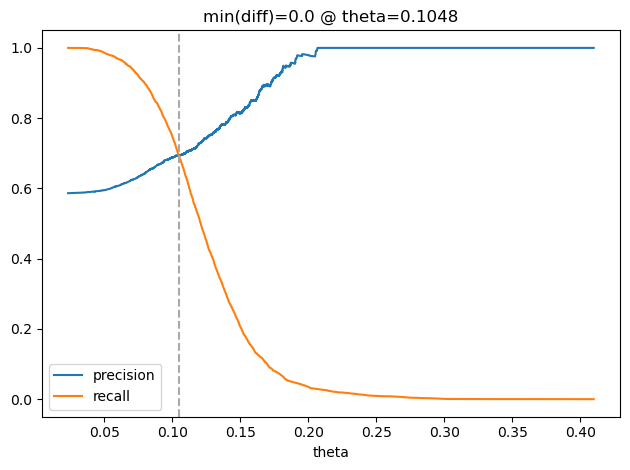

In [20]:
distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
diffs = np.abs(precisions - recalls)
max_diff_idx = np.array(diffs).argmin()
max_diff = diffs[max_diff_idx]
max_diff_th = thresholds[max_diff_idx]
print(f'max(f1)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.axvline(max_diff_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'min(diff)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')
plt.tight_layout()

In [21]:
calib_thresh = 1 - max_diff_th
calib_thresh

0.8952034924519071

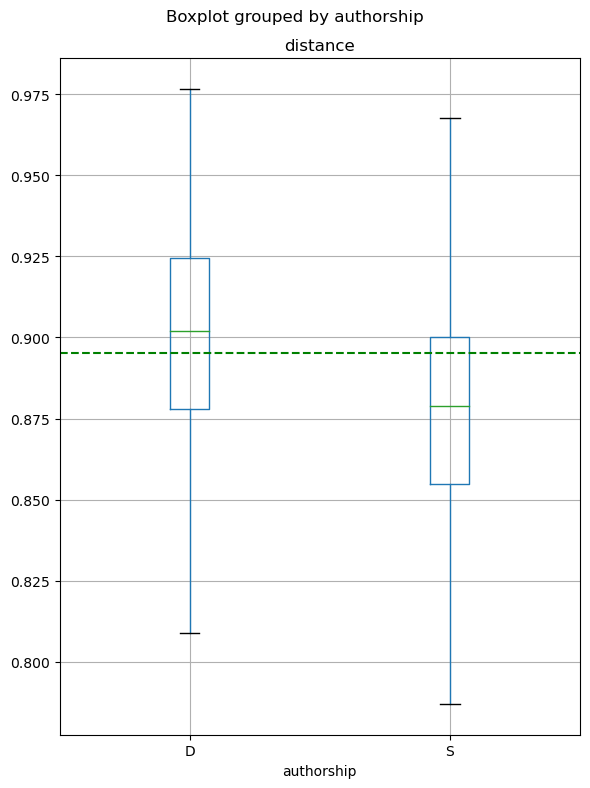

In [22]:
calib_distances.boxplot('distance', 'authorship', figsize=(6, 8), showfliers=False)
plt.axhline(calib_thresh, c='green', ls='--')
plt.tight_layout();

##### Target

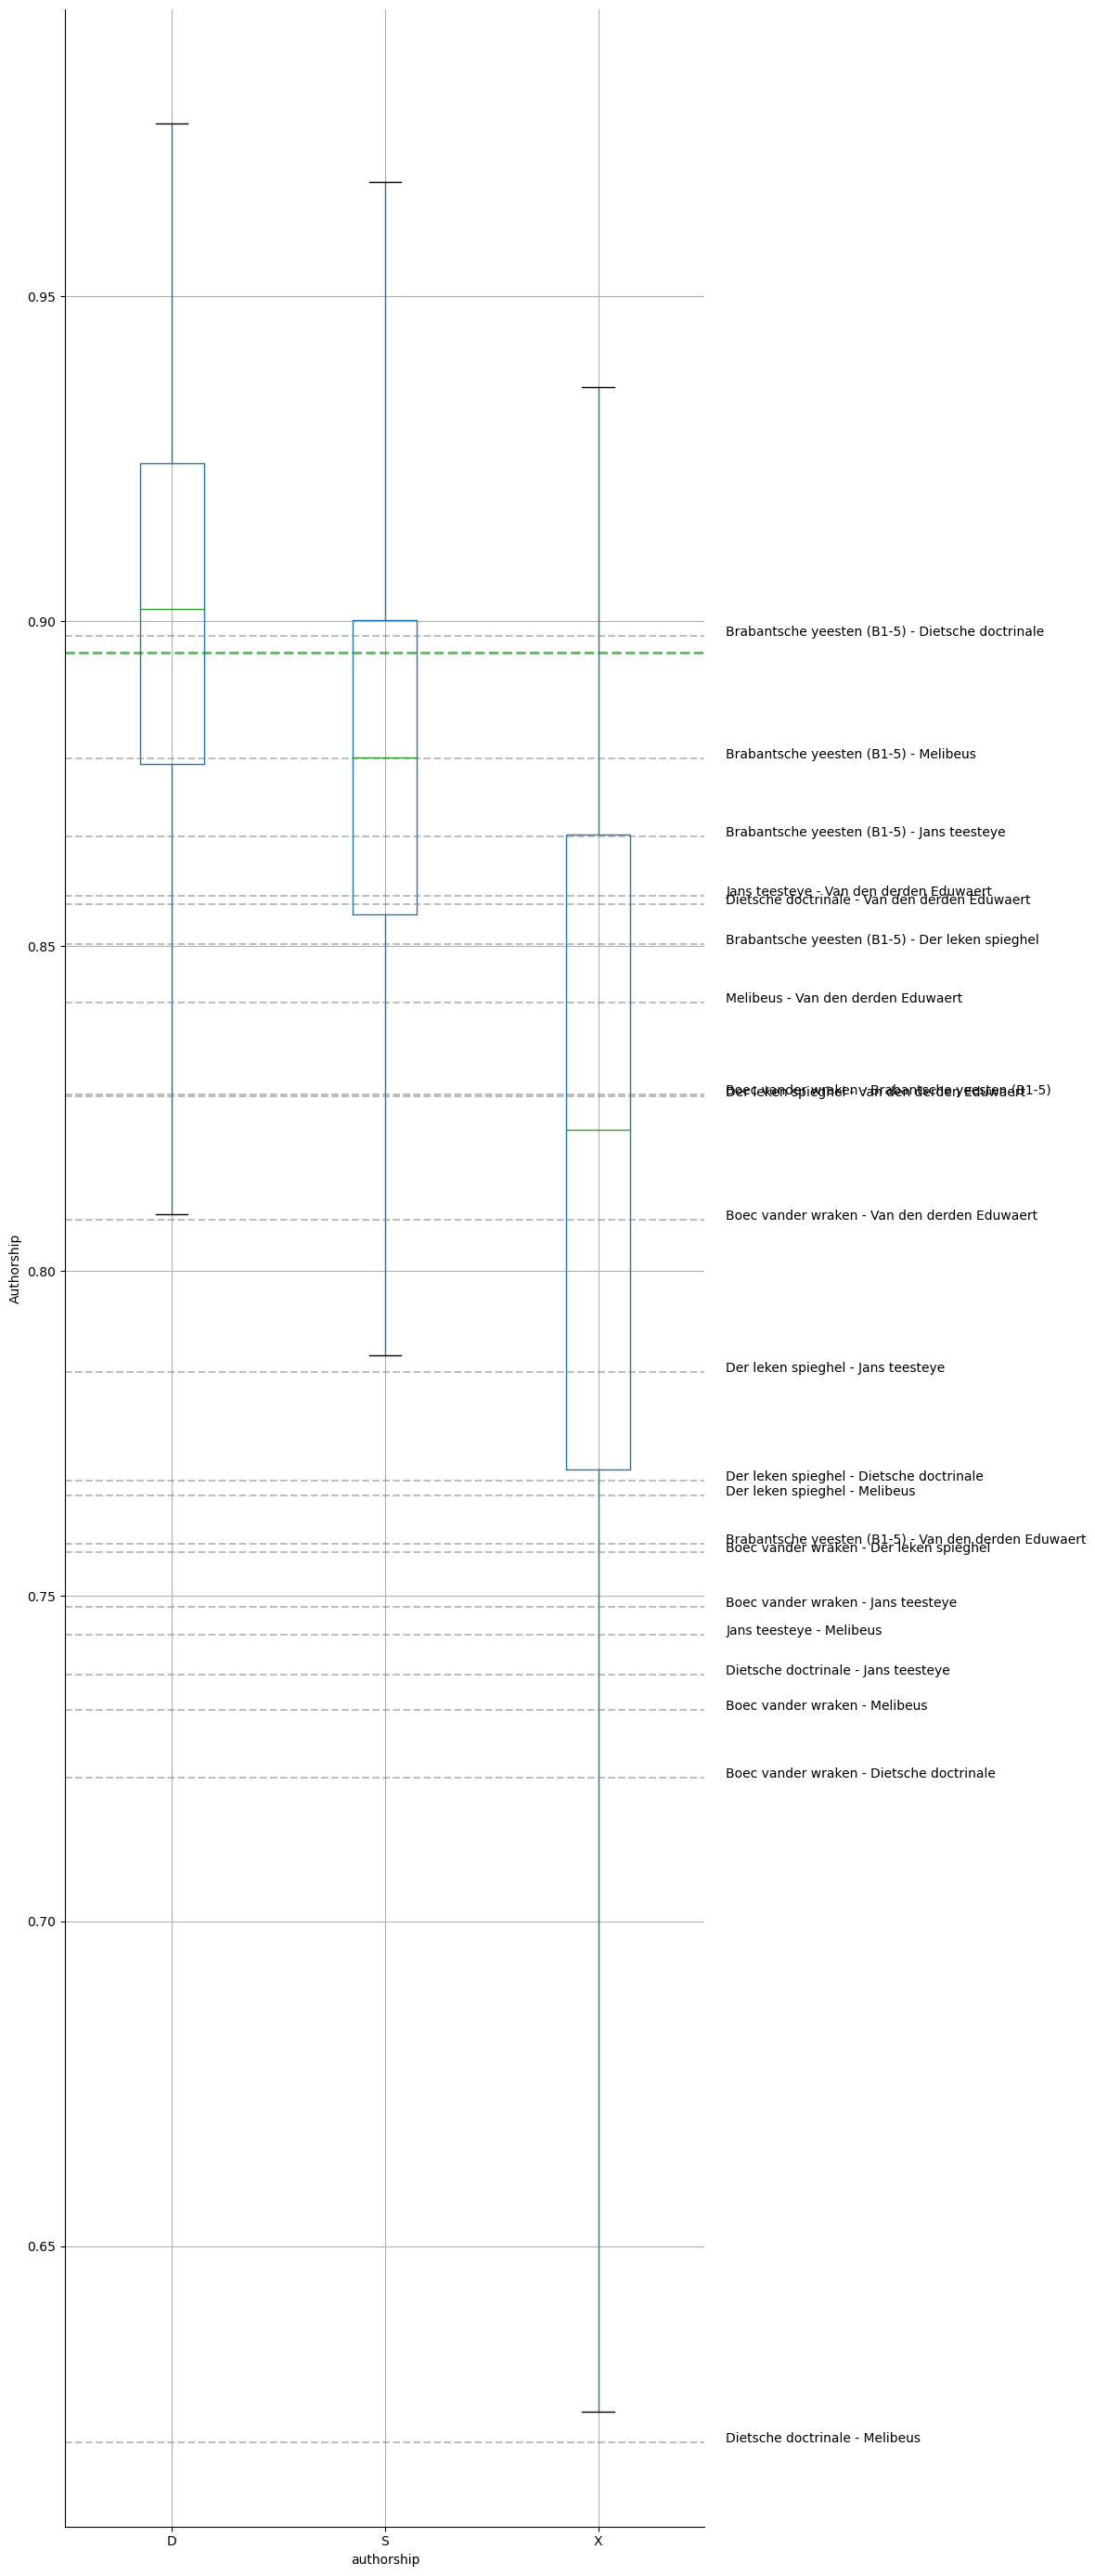

In [23]:
trg_X = vectorizer.transform(trg_df['text']).toarray()

combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'

trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
distances = pd.concat([calib_distances, trg_distances])

distances.boxplot('distance', 'authorship', figsize=(12, 28), showfliers=False)
sb.despine()
plt.axhline(calib_thresh, c='green', linewidth=2, ls='--', alpha=.6)

for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            plt.gca().axhline(d.mean(), c='grey', ls='--', alpha=.5)
            plt.annotate(' - '.join(m), xy=[plt.gca().get_xlim()[1]+0.1, d.mean()],
                         annotation_clip=False)
            
plt.title('')
plt.ylabel('Distance')
plt.ylabel('Authorship')
plt.suptitle('')

plt.tight_layout();

Dietsche doctrinael & Melibeus: zien we hier Albertanus of Boendale?

B5 en Eduwaert: inhoud nakijken maar hoogstwaarschiinlijk Boendale

Meeste afstand tussen BY 1-3 / 4-5 en andere werken: te verwachten
    Bij BY 1-3 en DD vergelijken we eigenlijk ook Maerlant en Albertanus
    
Dietsche doctrinael: 

Boec vander Wraken en BY 5 scoren nog relatief hoog: gek, want slot Wraken gaat terug op BY 5

BY 5 scoort relatief hoog met de rest <

## Networks

In [24]:
segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=2000)
segment_df.sample(5)

100%|████████████████████████████████████████| 162/162 [00:00<00:00, 460.79it/s]


,title,author,genre,subgenre,segment-idx,text
24,Brabantsche yeesten (B6),NaN,Epiek,Historiografie,1,"[almachtigheid, wijsheid, geest, volleest, licht, gesticht, aarde, gewaarden, macht, denken, bekennen, beginnen, waarachtigheid, drievuldigheid, na, gaan, in, zin, gicht, gedicht, geschieden, niet, stad, bat, historie, memorie, ruid, uiten, genoegen, voegen, vlieden, dat, vroed, bestaan, goed, nest, al, dal, lucht, vrucht, wens, mens, loon, troon, man, beginnen, kroniek, notabelijk, verklaren, worden, moeden, hoeden, zijn, pijn, verlichten, dichten, perselen, delen, graad, daad, wezen, lezen, vorst, durven, avontuur, zuur, horen, woord, verstaan, doen, bezinnen, kunnen, zin, innen, trouw, strooien, goed, est, est, ootmoedigheid, drivuldigheid, waken, volmaakt, brengen, kracht, weten, ongereed, kroniek, notabelijk, Jan, man, prijzen, wijzen, dood, groot, macht, volbrengen, zaak, maken, continueren, ...]"
174,Reinaerts historie,NaN,Epiek,Dier,3,"[groot, dood, lopen, roepen, verkopen, lopen, dat, schat, geven, schrijven, voet, vroed, lezen, wezen, trouw, rouwen, veer, geren, kind, zenden, zijn, zij, vroed, spoed, zitten, dat, zeer, eer, schrijven, geven, laten, baten, niet, verdriet, school, vool, lezen, wezen, Latijn, provincijn, school, veulen, audiëntie, sententie, licensierd, viseren, naam, ramen, vaart, Reinaard, schrijven, blijven, zullen, willen, hellen, geld, voet, doen, verdragen, beslaan, zes, mis, hoofd, verdoven, nijden, weder, rijden, haast, straat, laten, wonden, hond, zeer, heer, staan, zaten, mede, doen, maal, vocaal, voet, vroed, gij, wi, laten, begaden, steen, been, verheffen, schrijven, staan, wond, smijten, splijten, ontwee, mee, tellen, hellen, leven, hebben, ...]"
213,Rose,NaN,Epiek,Didactiek,5,"[Engeland, achemant, niet, zien, waarbij, gij, man, aan, gij, zij, waard, verteren, knaap, schaap, knecht, rechte, gaan, doen, lijden, zijn, wel, altemaal, ik, zij, verschuiven, beloven, worden, boebard, niet, plegen, zien, plegen, gaan, zaan, weg, weg, gewaad, schaden, zij, ik, omkleed, leed, veel, keel, dragen, behagen, bij, ik, goedertieren, manier, weder, nederen, schande, ande, blijven, wijf, vaardig, jegenwaardig, gehelen, kwelen, Robine, hoedje, gereed, God, bede, scheiden, dag, mogen, spreken, treek, paradijs, Denise, hij, vernemen, danschijn, zijn, mogen, slag, zwaar, daar, kwaad, verstaan, gaan, slaan, vingerlijn, zijn, riboud, zullen, wandelen, handelen, gij, ik, minne, beken, naar, daar, kwaad, raad, nemen, komen, ...]"
144,Merlijn,Jacob van Maerlant,Epiek,Arthur,4,"[waan, verstaan, hartelijk, gelijke, beide, gerei, zaan, doen, ontbieden, scheiden, echt, knecht, gereed, weten, zeggen, nederleggen, waan, verstaan, zullen, willen, al, zullen, raden, doen, nood, groot, bij, ik, weten, gereed, ik, nie, waarheid, zeggen, min, bekennen, doen, vroed, gij, bij, eer, meer, staan, gaan, zaan, vergaan, uw, nu, gaan, raad, niet, zien, eer, meer, leed, gereed, tegen, oog, tijd, zijn, zaal, mal, zijn, zij, staan, raad, dan, man, hof, oorlof, gaan, gedaan, zijn, das, manier, schier, gaan, zaan, uiten, geluid, leggen, greien, spreken, zaak, zijn, zijn, al, zullen, vergaan, zaan, vragen, verdagen, feest, allermeeste, geboren, voren, bidden, stade, Merlijn, divijn, ...]"
139,Madelgijs,NaN,Epiek,Karel,1,"[waan, suptiel, wijl, dienst, zienste, varen, sparen, fi, ik, blijven, schrijven, tellen, zullen, toilet, met, doen, prisoen, wel, snel, madelgijs, wijs, gewagen, dag, waarheid, stede, horen, toren, toverij, nie, komen, vernemen, hemd, vreemd, aan, geprenden, sprake, man, Jan, blij, zijde, aarde, zwoerd, schoen, toen, kruin, schreien, genezen, stond, zenden, Istorië, geschieden, woord, waard, paard, vroed, mede, samen, komen, waan, jeest, foreest, blijven, beschrijven, verstaan, waan, stad, bet, nemen, komen, eten, zitten, voort, behoren, delen, parselen, wonden, stonde, vuur, schier, paap, traap, zijn, das, man, onnen, paard, vaart, willen, houden, knaap, genoeg, Louch, rijden, varen, verklaren, madelgijs, waart, bezwaren,

In [25]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               width=1000,
               height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="5pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)

sub_df = segment_df[segment_df['subgenre'].isin({'Didactiek', 'Historiografie'})]
sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]

params = {'use_idf': True,
          'max_features': 500,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=20)
X = pca.fit_transform(BOW)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

scatterplot(X, sub_df, label_column='title', color_column='title')

In [26]:
sub_df = segment_df[segment_df['title'].isin({'Limborch', 'Rose', 'Roman van Cassamus (kort)',
                                              'Borchgravinne van Vergi (1)',
                                              'Roman der Lorreinen II',
                                              'Alexanders geesten',
                                              'Historie van Troyen',
                                              'Roman van Caesar',
                                              'Grimbergse oorlog', 'Grimbergse oorlog (cont)',
                                              'Rijmkroniek van Woeringen',
                                             })]
sub_df = trg_df

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
BOW = StandardScaler().fit_transform(BOW)

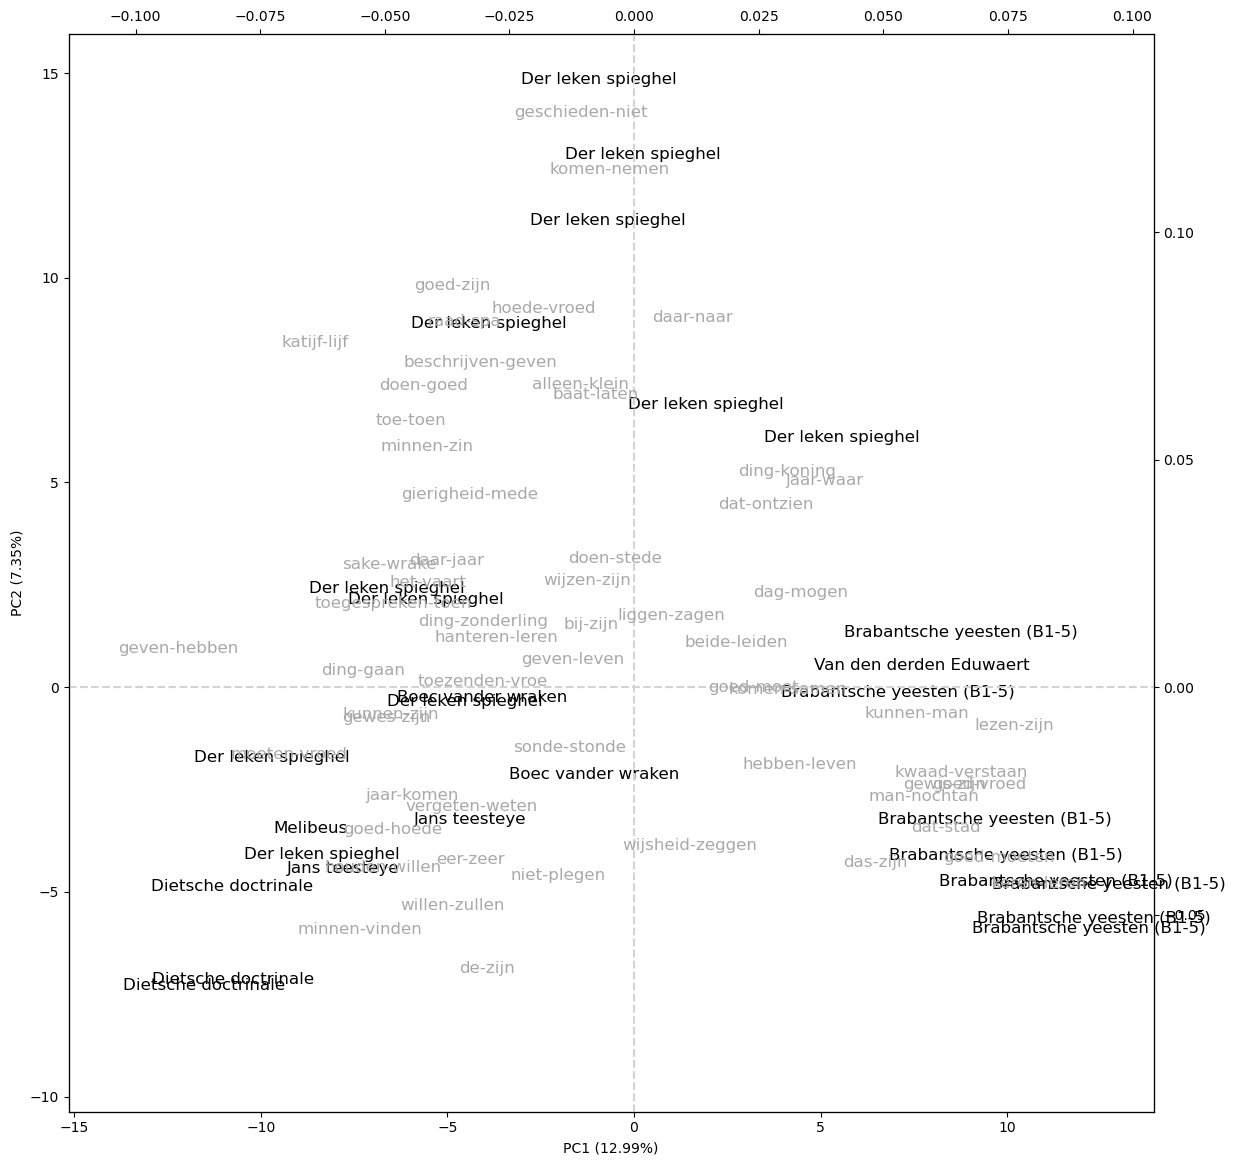

In [27]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

## Verification

In [28]:
params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
epics = segment_df[segment_df['genre'] == 'Epiek'].copy().reindex()
vectorizer.fit(epics['text'])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

(333, 10000)

In [29]:
num_iter = 250
total_features = len(vectorizer.get_feature_names_out())
num_rnd_features = int(total_features * .5)
n_top_neighbors = 5

target_titles = [#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                 'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken']

results = []

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    top_neighbors = neighbors.most_common(n_top_neighbors)
    summed = sum(neighbors.values())
    top_neighbors = [f'{k} ({(v / summed) * 100:.2f}%)' for k, v in top_neighbors]
    
    results.append([target_title] + top_neighbors)
    
results = pd.DataFrame(results, columns=['Target']+[f'Rank {i + 1}' for i in range(n_top_neighbors)])
results

Brabantsche yeesten (B5): 0it [00:00, ?it/s]
Korte kroniek van Brabant (korte versie 1): 0it [00:00, ?it/s]
Melibeus: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]
Boec Exemplaer: 0it [00:00, ?it/s]
Boec vander wraken: 100%|█████████████████████████| 2/2 [00:00<00:00,  2.03it/s]


,Target,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
0,Brabantsche yeesten (B5),None,None,None,None,None
1,Korte kroniek van Brabant (korte versie 1),None,None,None,None,None
2,Der leken spieghel,Boec vander wraken (39.38%),Dietsche doctrinale (22.25%),Melibeus (12.65%),Jans teesteye (8.80%),Der ystorien bloeme (3.96%)
3,Jans teesteye,Dietsche doctrinale (46.00%),Boec vander wraken (25.40%),Melibeus (19.80%),Der leken spieghel (8.80%),None
4,Van den derden Eduwaert,Brabantsche yeesten (B1-5) (51.20%),Boec vander wraken (13.60%),Der ystorien bloeme (6.00%),Der leken spieghel (4.80%),Spiegel historiael (P5) (4.00%)
5,Melibeus,Dietsche doctrinale (96.80%),Der leken spieghel (2.80%),Boec vander wraken (0.40%),None,None
6,Boec Exemplaer,None,None,None,None,None
7,Dietsche doctrinale,Melibeus (96.67%),Der leken spieghel (2.67%),Boec vander wraken (0.53%),Jans teesteye (0.13%),None
8,Boec vander wraken,Dietsche doctrinale (51.40%),Melibeus (28.40%),Der leken spieghel (14.20%),Jans teesteye (5.20%),Der ystorien bloeme (0.60%)


## Feature analysis

### "Oeuvre"

In [30]:
BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'].isin(['Brabantsche yeesten (B1-3)', 
                                 'Brabantsche yeesten (B4-5)',
                                 'Brabantsche yeesten (B5)',
                                 'Korte kroniek van Brabant (korte versie 1)',
                                 'Der leken spieghel', 'Jans teesteye', 
                                 'Van den derden Eduwaert', 'Melibeus', 'Boec Exemplaer', 
                                 'Dietsche doctrinale', 'Boec vander wraken'])

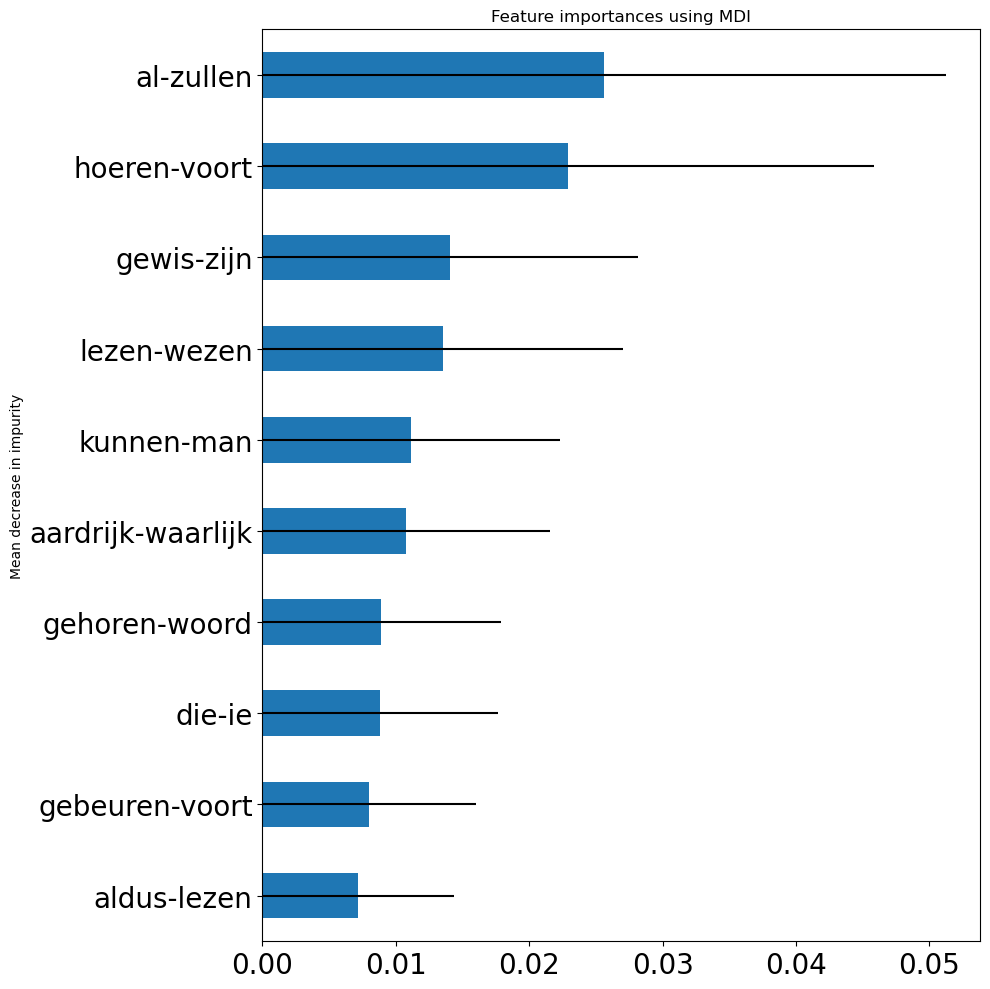

In [31]:
classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


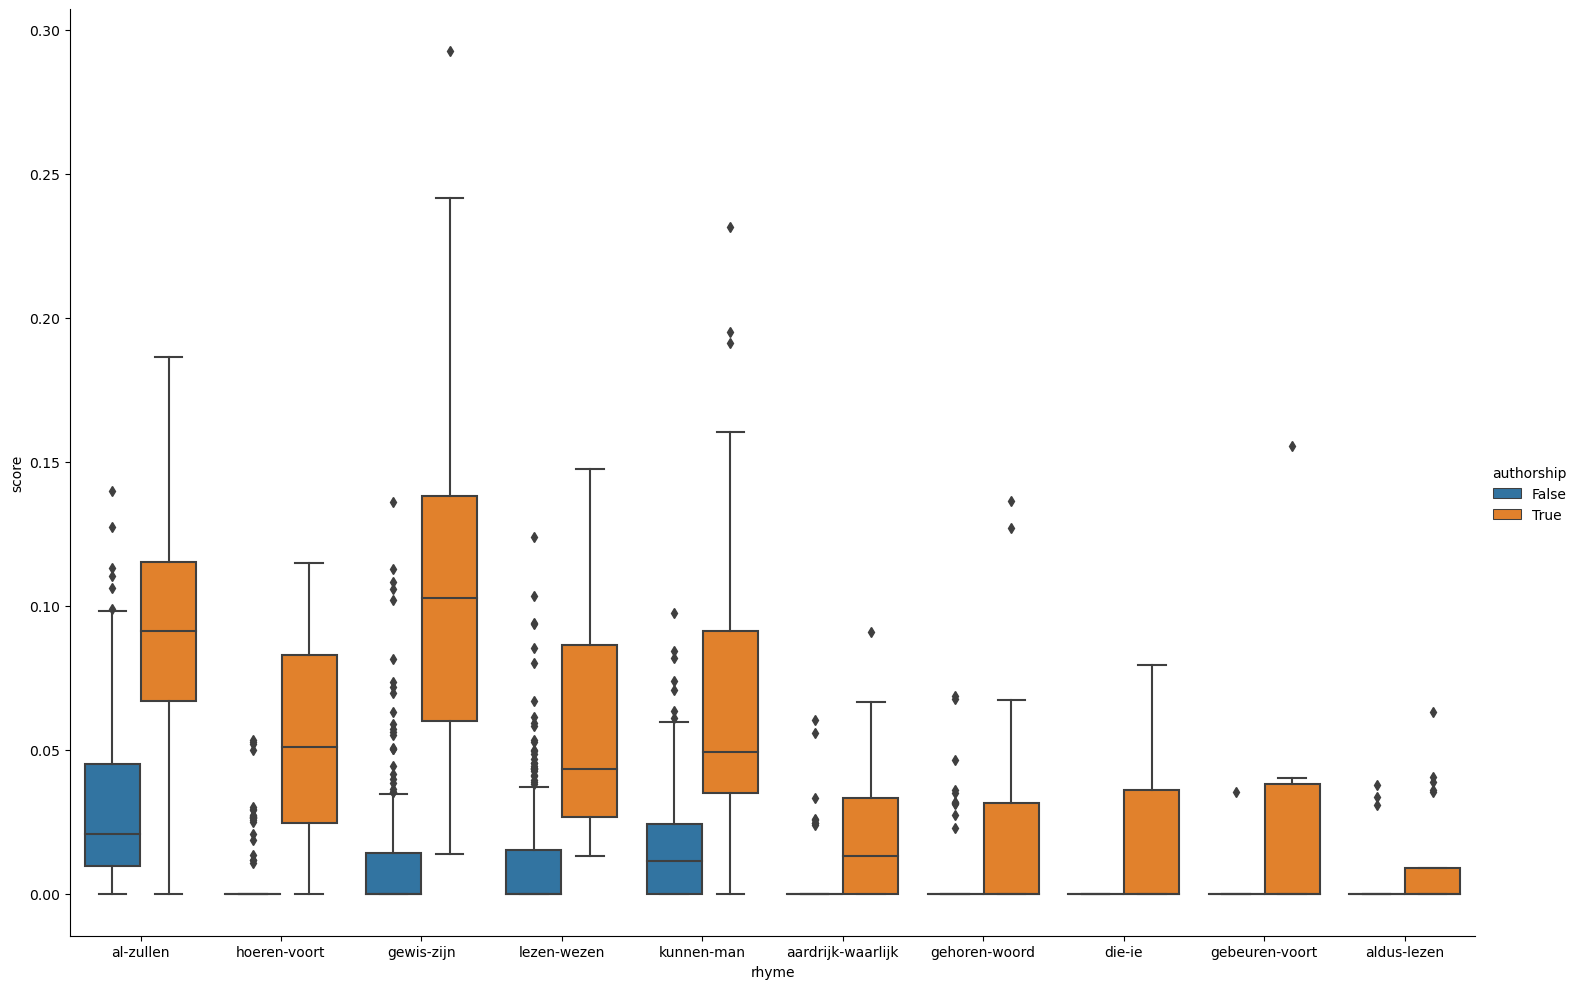

In [32]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);

## Jans teesteye

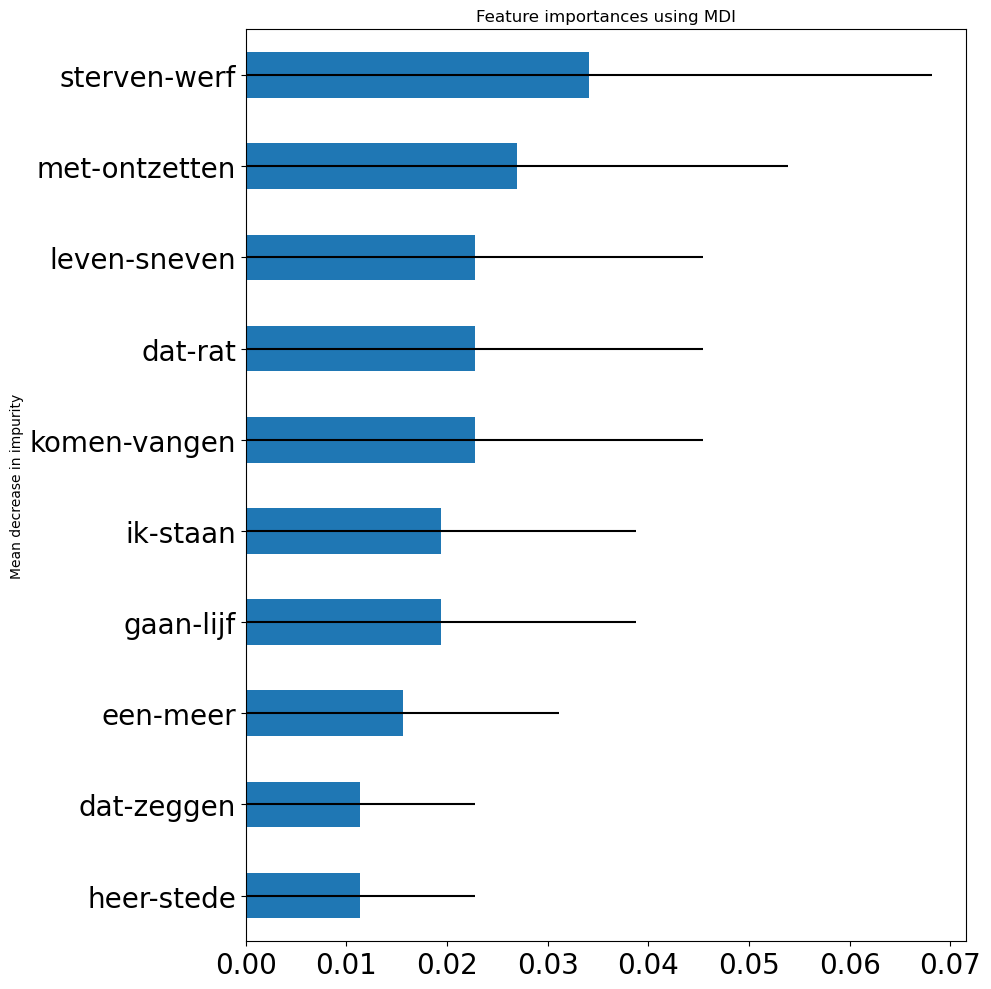

In [33]:
epics = epics[epics['title'].isin(['Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                   'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken'])]
segment_X = vectorizer.transform(epics['text']).toarray()

BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'] == 'Jans teesteye'

classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


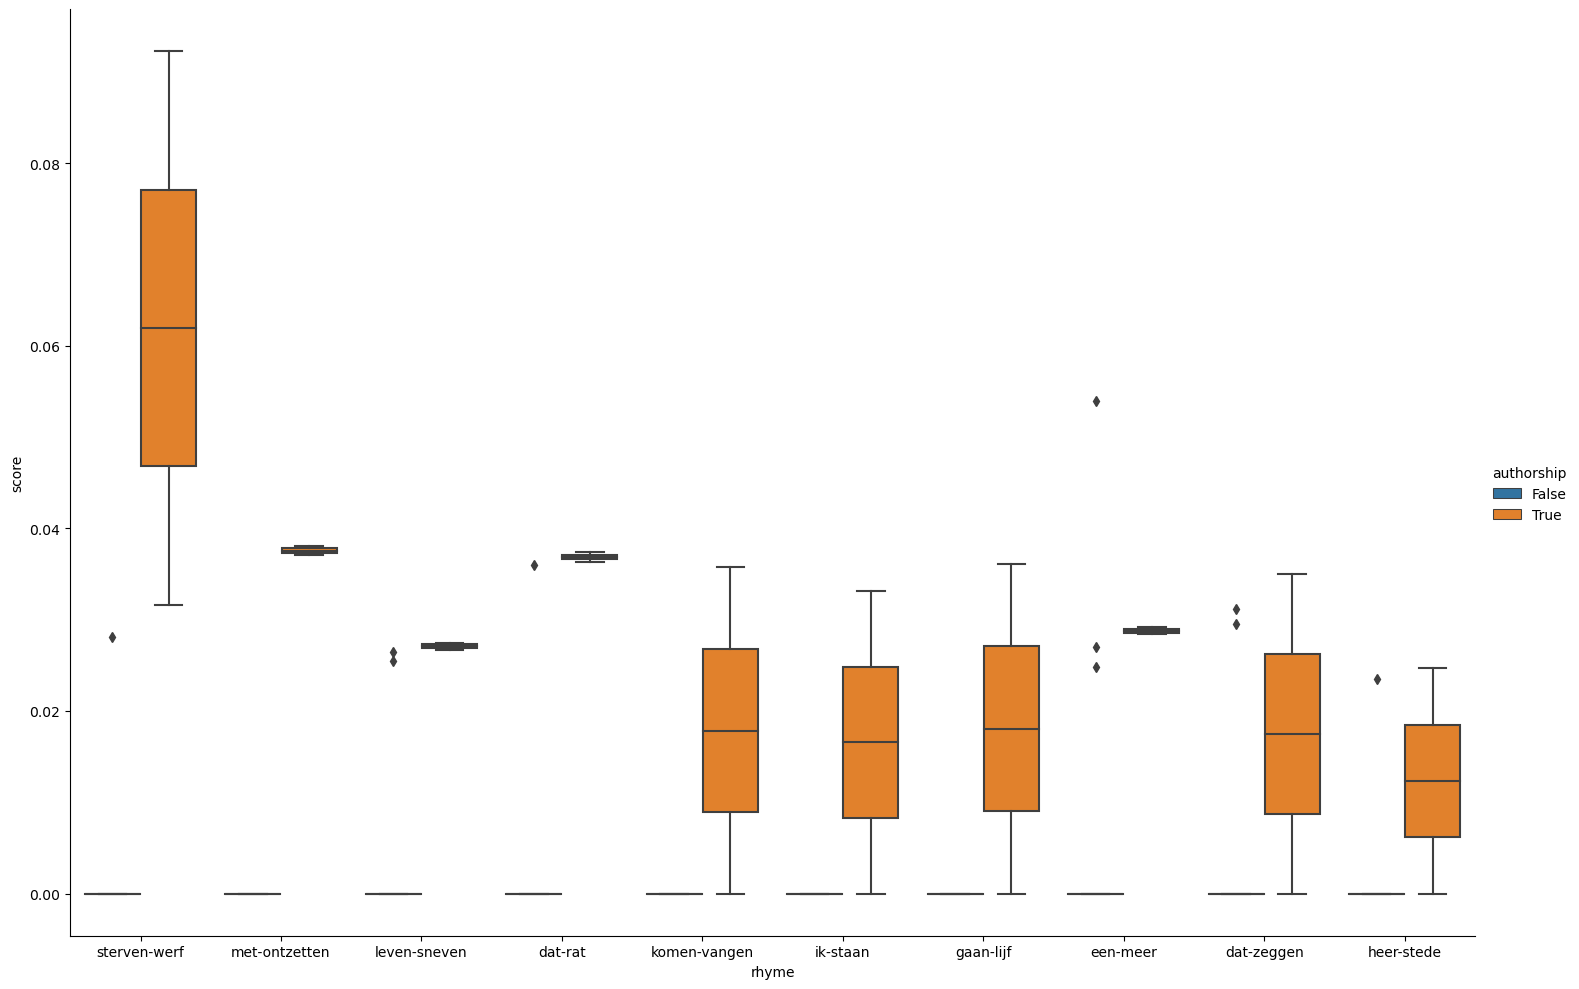

In [34]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);